In [66]:
# Importing the required libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [67]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
from functools import partial

In [69]:
from dotenv import load_dotenv

from pathlib import Path

env_path = Path("../../.env-live")

if env_path.exists():
    print('envs Loaded')
    load_dotenv(dotenv_path=env_path)
from jrjModelRegistry.jrjModelRegistry import registerAJrjModel

envs Loaded


In [70]:
def generalDtPredictor(self, transformedData):
    import pandas as pd
    probs = self.predict_proba(transformedData)
    return pd.Series(probs[:, 1])

In [71]:
def generalDtTransformer(dataForTransfer = None):
    import pandas as pd
    if isinstance(dataForTransfer, pd.DataFrame):
        df = dataForTransfer.copy()
    else:
        df = pd.DataFrame(dataForTransfer)
    return df

In [72]:
# Reading the csv file and putting it into 'df' object.
df = pd.read_csv('heart_v2.csv')

In [73]:
df.columns

Index(['age', 'sex', 'BP', 'cholestrol', 'heart disease'], dtype='object')

In [74]:
df.head()

,age,sex,BP,cholestrol,heart disease
0,70,1,130,322,1
1,67,0,115,564,0
2,57,1,124,261,1
3,64,1,128,263,0
4,74,0,120,269,0


In [75]:
hDSampleData = {
    "age": [70],
    "sex": [1],
    "BP": [130],
    "cholestrol": [322],
}
hDSampleData

{'age': [70], 'sex': [1], 'BP': [130], 'cholestrol': [322]}

In [76]:
# Putting feature variable to X
X = df.drop('heart disease',axis=1)

# Putting response variable to y
y = df['heart disease']

In [77]:
from sklearn.model_selection import train_test_split

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((189, 4), (81, 4))

Fitting the decision tree with default hyperparameters, apart from max_depth which is 3 so that we can plot and read the tree.

In [79]:
from sklearn.tree import DecisionTreeClassifier

In [80]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [81]:
!pip install six

In [82]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

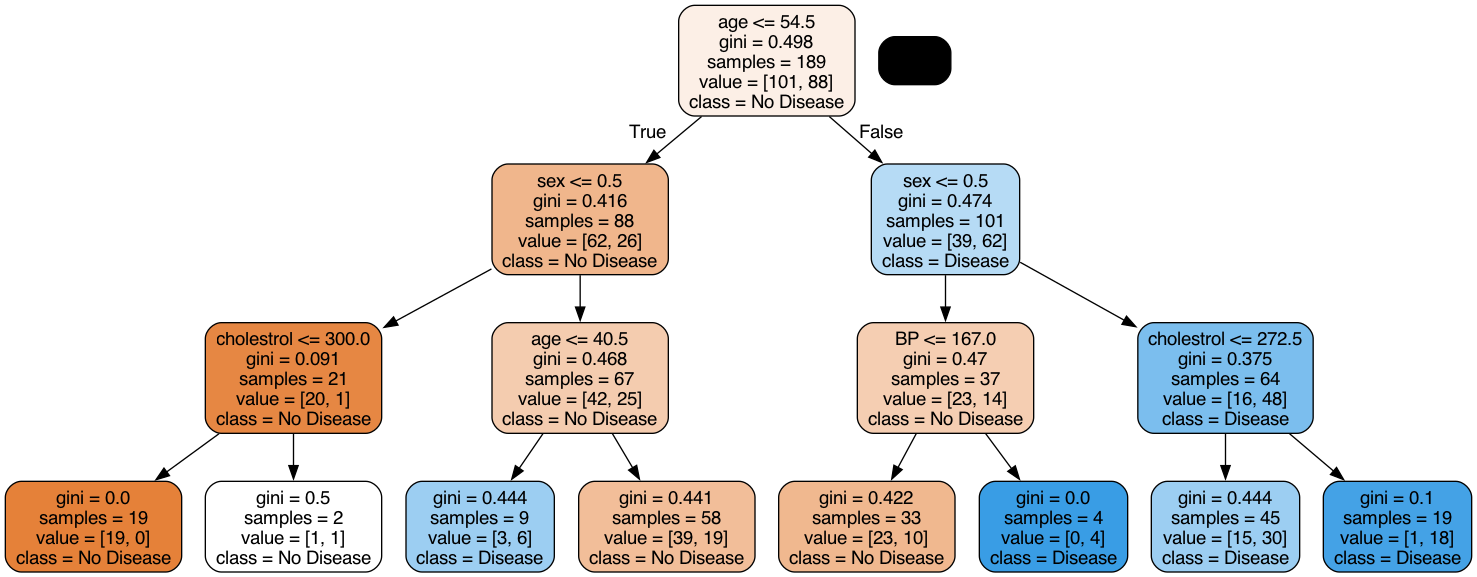

In [83]:
# plotting tree with max_depth=3
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['No Disease', "Disease"])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
#Image(graph.create_png(),width=800,height=900)
#graph.write_pdf("dt_heartdisease.pdf")

#### Evaluating model performance

In [84]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [86]:
print(accuracy_score(y_train, y_train_pred))
confusion_matrix(y_train, y_train_pred)

0.7407407407407407


array([[82, 19],
       [30, 58]])

In [87]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.6049382716049383


array([[35, 14],
       [18, 14]])

Creating helper functions to evaluate model performance and help plot the decision tree

In [88]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=X.columns, 
                    class_names=['Disease', "No Disease"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [89]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

### Without setting any hyper-parameters

In [90]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

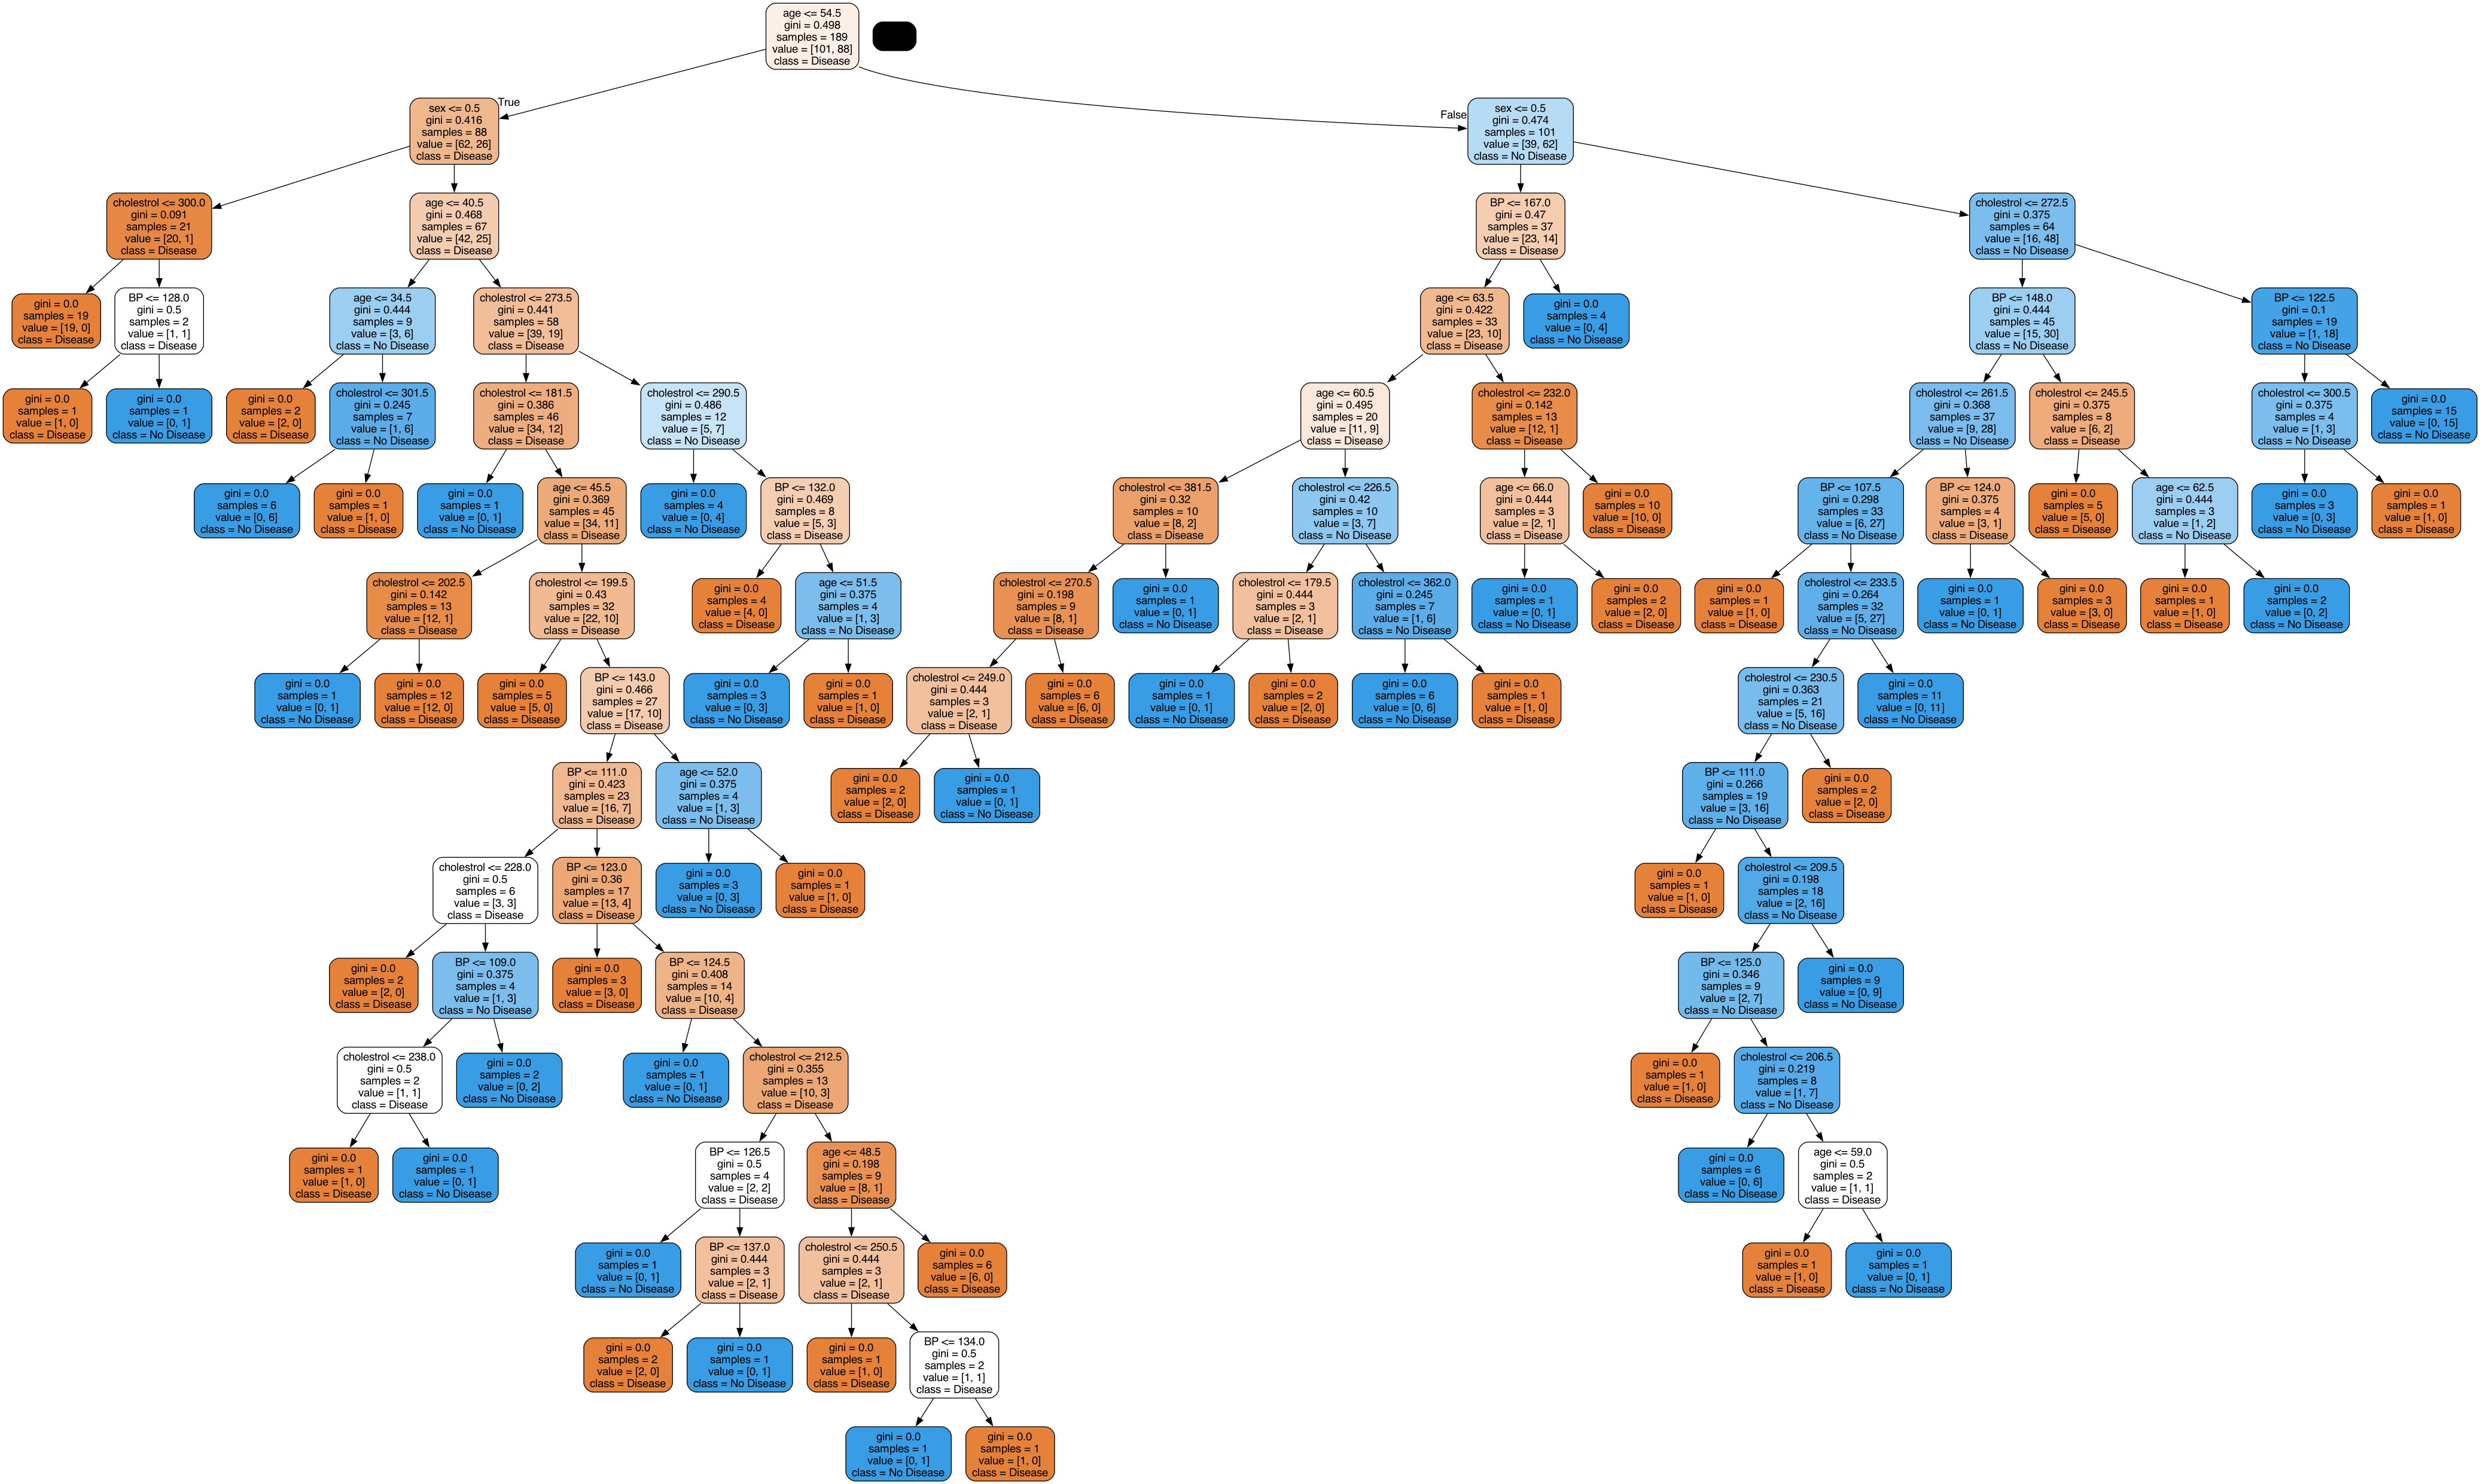

In [91]:
gph = get_dt_graph(dt_default)
Image(gph.create_png())

In [92]:
evaluate_model(dt_default)

Train Accuracy : 1.0
Train Confusion Matrix:
[[101   0]
 [  0  88]]
--------------------------------------------------
Test Accuracy : 0.6296296296296297
Test Confusion Matrix:
[[31 18]
 [12 20]]


In [93]:
from sklearn.metrics import accuracy_score, classification_report
import json

In [94]:
dt_default.transformer = generalDtTransformer
dt_default.mainPredictor = partial(generalDtPredictor,dt_default)

In [95]:
y_pred = dt_default.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

In [96]:
dt_default_metadata = {
    "modelName": "dTModelDefault",
    "version": "1.0.1",
    "params": dt_default.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_default.feature_importances_.tolist(),
        "n_features": int(dt_default.n_features_in_),
        "n_classes": int(dt_default.n_classes_),
        "classes": dt_default.classes_.tolist(),
        "depth": int(dt_default.get_depth()),
        "n_leaves": int(dt_default.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}

In [97]:
registerAJrjModel(
    dt_default,
    dt_default_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelDefault__1.0.1.pkl.zip
❌ Failed to generate URL or upload: E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelDefault", version: "1.0.1" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelDefault", version: "1.0.1" }', 'keyPattern': {'modelName': 1, 'version': 1}, 'keyValue': {'modelName': 'dTModelDefault', 'version': '1.0.1'}}


### Controlling the depth of the tree

In [98]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

In [99]:
dt_depth = DecisionTreeClassifier(max_depth=3)
dt_depth.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

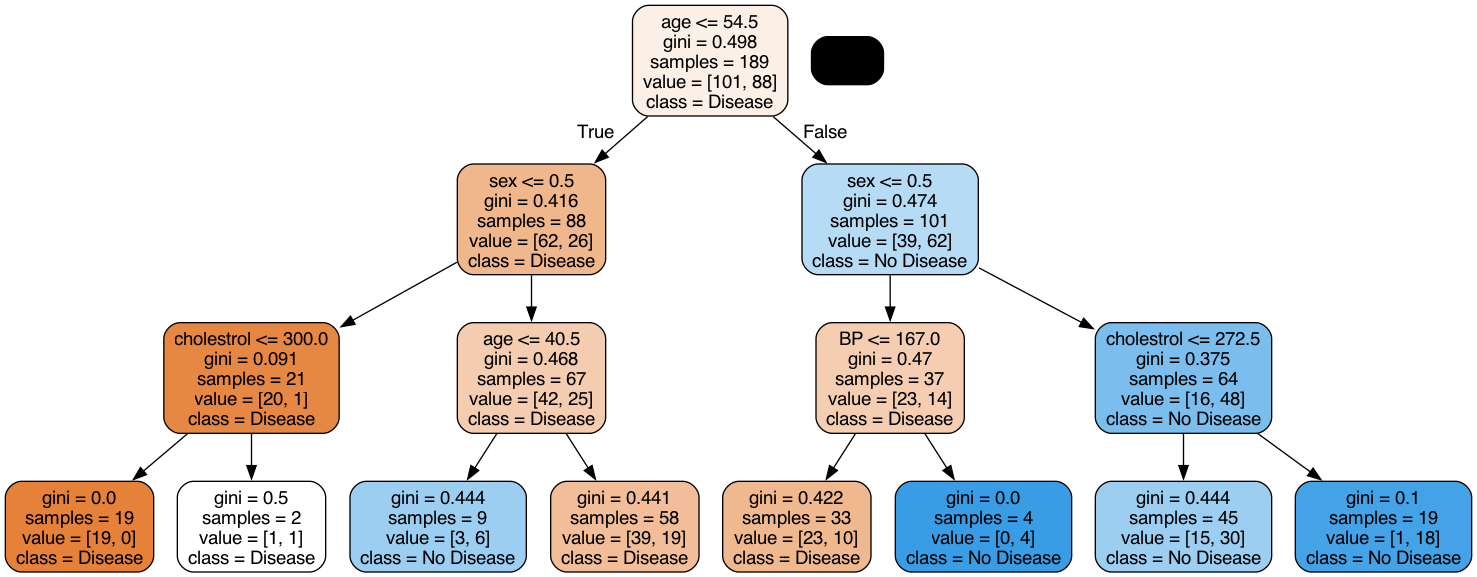

In [100]:
gph = get_dt_graph(dt_depth) 
Image(gph.create_png())

In [101]:
evaluate_model(dt_depth)

Train Accuracy : 0.7407407407407407
Train Confusion Matrix:
[[82 19]
 [30 58]]
--------------------------------------------------
Test Accuracy : 0.6049382716049383
Test Confusion Matrix:
[[35 14]
 [18 14]]


In [102]:
dt_depth.transformer = generalDtTransformer
dt_depth.mainPredictor = partial(generalDtPredictor,dt_depth)
y_pred = dt_depth.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

dt_depth_metadata = {
    "modelName": "dTModelDepth",
    "version": "1.0.1",
    "params": dt_depth.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_depth.feature_importances_.tolist(),
        "n_features": int(dt_depth.n_features_in_),
        "n_classes": int(dt_depth.n_classes_),
        "classes": dt_depth.classes_.tolist(),
        "depth": int(dt_depth.get_depth()),
        "n_leaves": int(dt_depth.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}
registerAJrjModel(
    dt_depth,
    dt_depth_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelDepth__1.0.1.pkl.zip
❌ Failed to generate URL or upload: E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelDepth", version: "1.0.1" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelDepth", version: "1.0.1" }', 'keyPattern': {'modelName': 1, 'version': 1}, 'keyValue': {'modelName': 'dTModelDepth', 'version': '1.0.1'}}


### Specifying minimum samples before split

In [103]:
dt_min_split = DecisionTreeClassifier(min_samples_split=20)
dt_min_split.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=20)

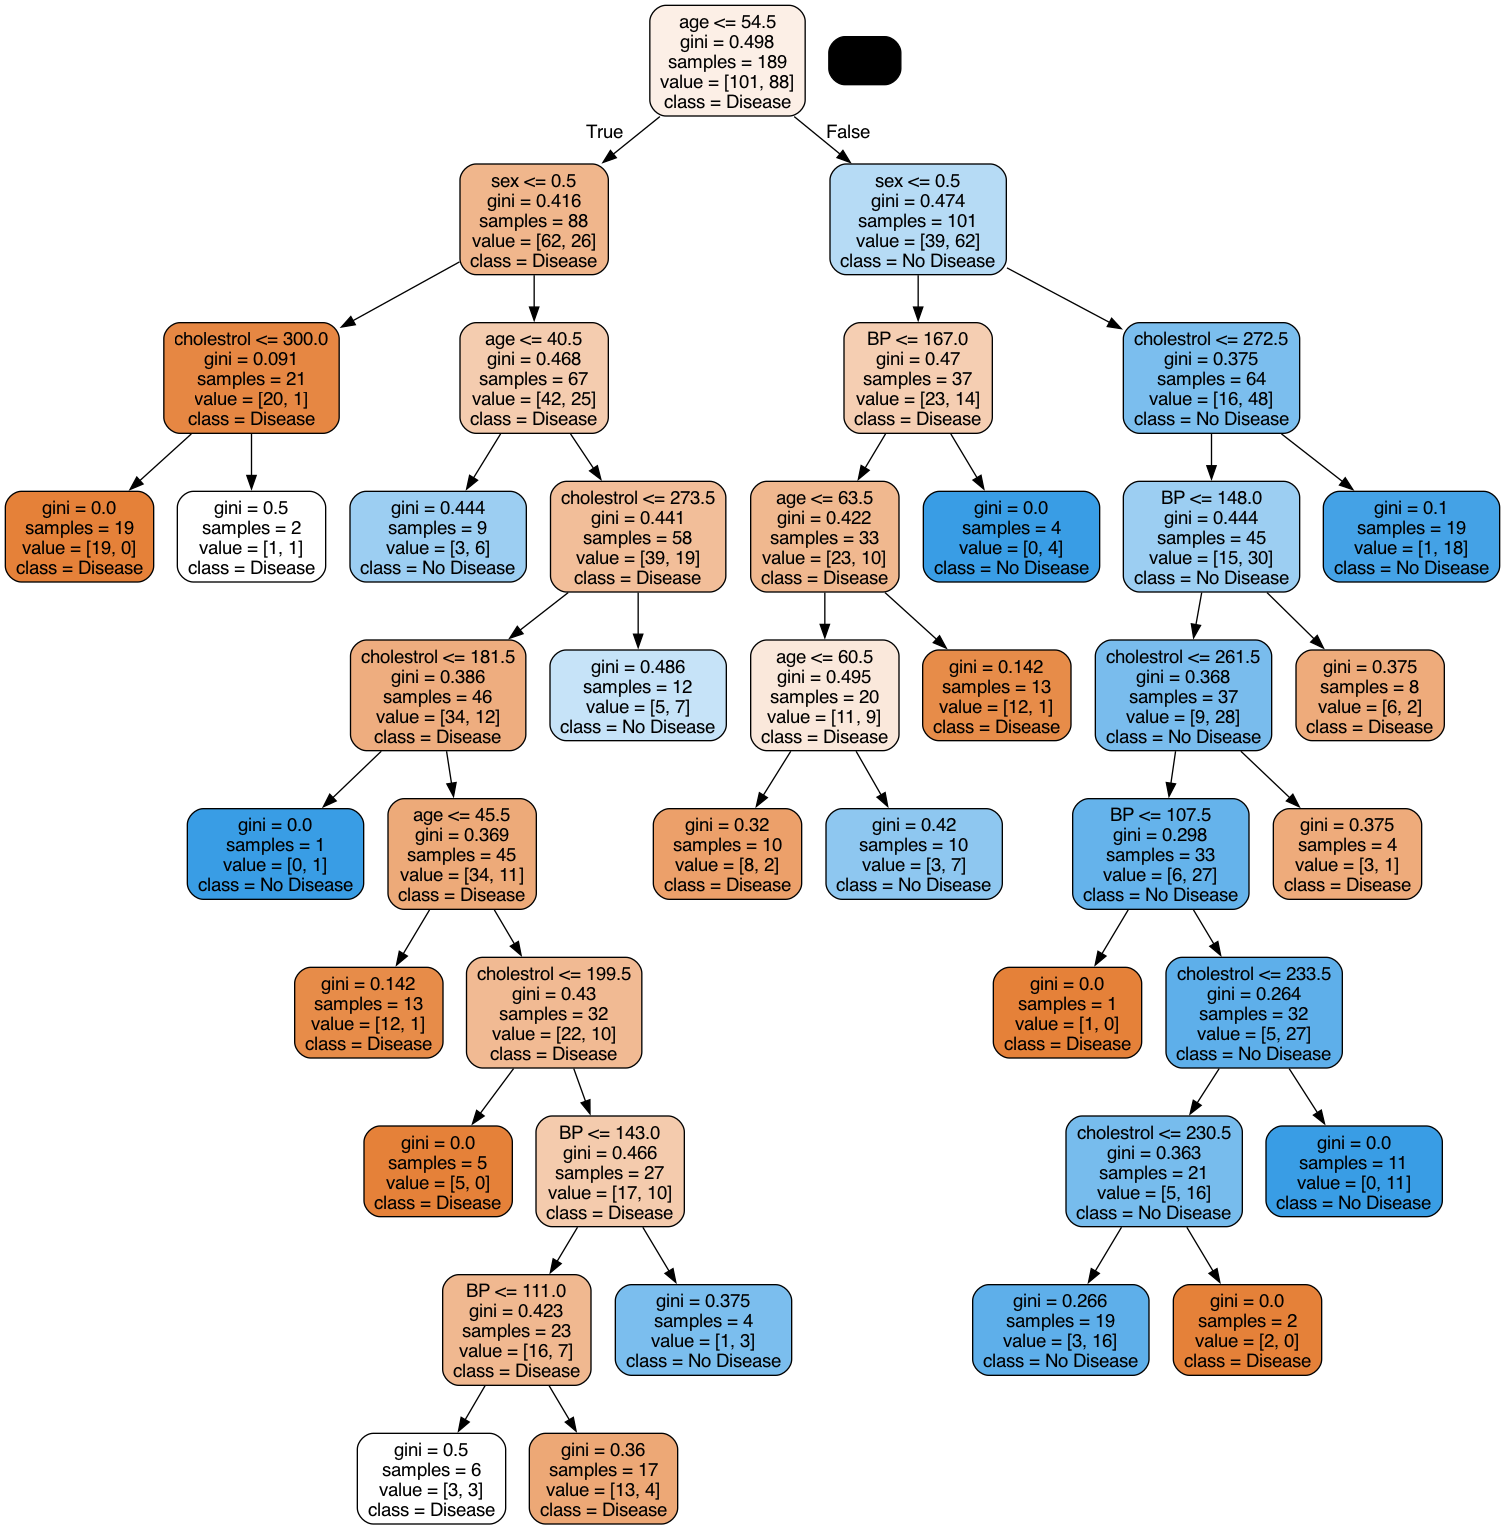

In [104]:
gph = get_dt_graph(dt_min_split) 
Image(gph.create_png())

In [105]:
evaluate_model(dt_min_split)

Train Accuracy : 0.8359788359788359
Train Confusion Matrix:
[[85 16]
 [15 73]]
--------------------------------------------------
Test Accuracy : 0.6419753086419753
Test Confusion Matrix:
[[32 17]
 [12 20]]


In [106]:
dt_min_split.transformer = generalDtTransformer
dt_min_split.mainPredictor = partial(generalDtPredictor,dt_min_split)
y_pred = dt_min_split.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

dt_min_split_metadata = {
    "modelName": "dTModelMinSplit",
    "version": "1.0.1",
    "params": dt_min_split.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_min_split.feature_importances_.tolist(),
        "n_features": int(dt_min_split.n_features_in_),
        "n_classes": int(dt_min_split.n_classes_),
        "classes": dt_min_split.classes_.tolist(),
        "depth": int(dt_min_split.get_depth()),
        "n_leaves": int(dt_min_split.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}
registerAJrjModel(
    dt_min_split,
    dt_min_split_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelMinSplit__1.0.1.pkl.zip
❌ Failed to generate URL or upload: E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelMinSplit", version: "1.0.1" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelMinSplit", version: "1.0.1" }', 'keyPattern': {'modelName': 1, 'version': 1}, 'keyValue': {'modelName': 'dTModelMinSplit', 'version': '1.0.1'}}


### Specifying minimum samples in leaf node

In [107]:
dt_min_leaf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
dt_min_leaf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

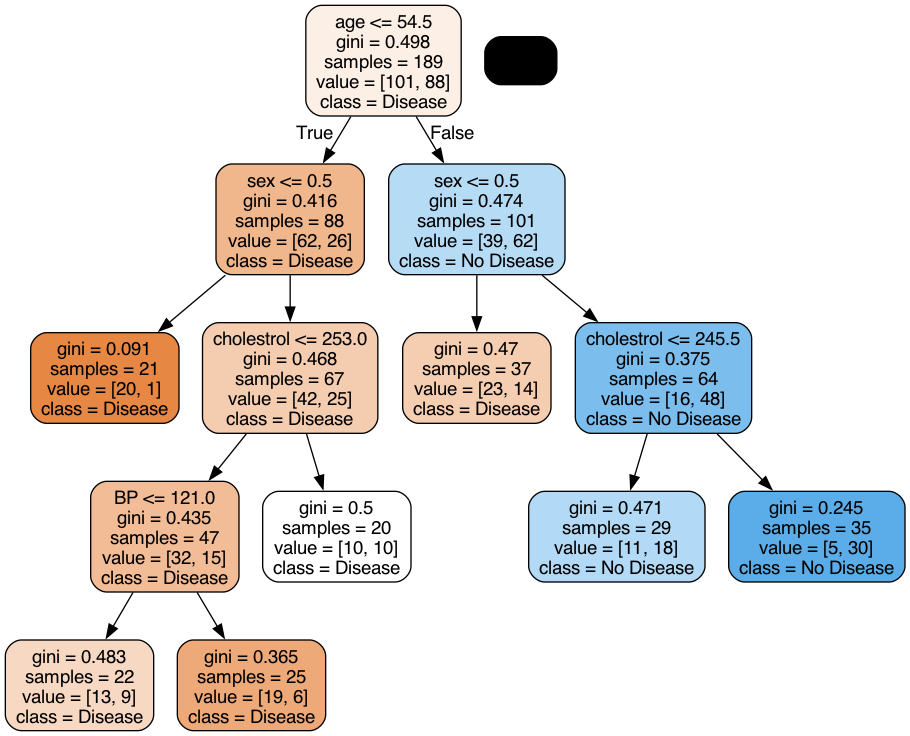

In [108]:
gph = get_dt_graph(dt_min_leaf)
Image(gph.create_png())

In [109]:
evaluate_model(dt_min_leaf)

Train Accuracy : 0.7037037037037037
Train Confusion Matrix:
[[85 16]
 [40 48]]
--------------------------------------------------
Test Accuracy : 0.6419753086419753
Test Confusion Matrix:
[[38 11]
 [18 14]]


In [110]:
dt_min_leaf.transformer = generalDtTransformer
dt_min_leaf.mainPredictor = partial(generalDtPredictor,dt_min_leaf)
y_pred = dt_min_leaf.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

dt_min_leaf_metadata = {
    "modelName": "dTModelMinLeaf",
    "version": "1.0.1",
    "params": dt_min_leaf.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_min_leaf.feature_importances_.tolist(),
        "n_features": int(dt_min_leaf.n_features_in_),
        "n_classes": int(dt_min_leaf.n_classes_),
        "classes": dt_min_leaf.classes_.tolist(),
        "depth": int(dt_min_leaf.get_depth()),
        "n_leaves": int(dt_min_leaf.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}
registerAJrjModel(
    dt_min_leaf,
    dt_min_leaf_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelMinLeaf__1.0.1.pkl.zip
❌ Failed to generate URL or upload: E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelMinLeaf", version: "1.0.1" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelMinLeaf", version: "1.0.1" }', 'keyPattern': {'modelName': 1, 'version': 1}, 'keyValue': {'modelName': 'dTModelMinLeaf', 'version': '1.0.1'}}


### Using Entropy instead of Gini

In [111]:
dt_min_leaf_entropy = DecisionTreeClassifier(min_samples_leaf=20, random_state=42, criterion="entropy")
dt_min_leaf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=20,
                       random_state=42)

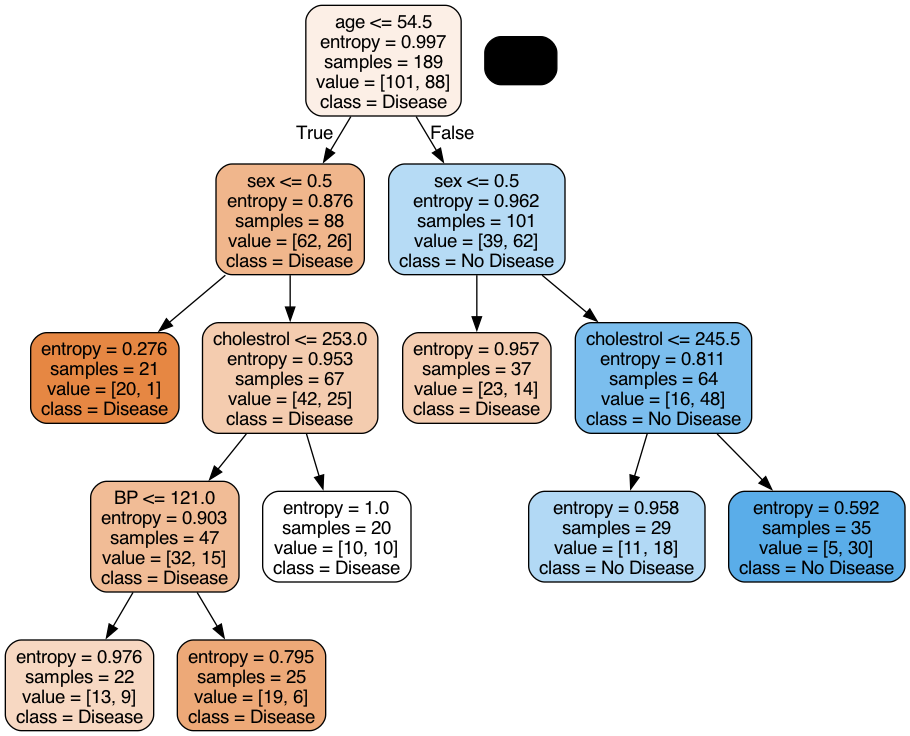

In [112]:
gph = get_dt_graph(dt_min_leaf_entropy)
Image(gph.create_png())

In [113]:
evaluate_model(dt_min_leaf_entropy)

Train Accuracy : 0.7037037037037037
Train Confusion Matrix:
[[85 16]
 [40 48]]
--------------------------------------------------
Test Accuracy : 0.6419753086419753
Test Confusion Matrix:
[[38 11]
 [18 14]]


In [114]:
dt_min_leaf_entropy.transformer = generalDtTransformer
dt_min_leaf_entropy.mainPredictor = partial(generalDtPredictor,dt_min_leaf_entropy)
y_pred = dt_min_leaf_entropy.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

dt_min_leaf_entropy_metadata = {
    "modelName": "dTModelMinLeafEntropy",
    "version": "1.0.1",
    "params": dt_min_leaf_entropy.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_min_leaf_entropy.feature_importances_.tolist(),
        "n_features": int(dt_min_leaf_entropy.n_features_in_),
        "n_classes": int(dt_min_leaf_entropy.n_classes_),
        "classes": dt_min_leaf_entropy.classes_.tolist(),
        "depth": int(dt_min_leaf_entropy.get_depth()),
        "n_leaves": int(dt_min_leaf_entropy.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}
registerAJrjModel(
    dt_min_leaf_entropy,
    dt_min_leaf_entropy_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelMinLeafEntropy__1.0.1.pkl.zip


{'_id': '6855408e38947ba330a5f872',
 'modelName': 'dTModelMinLeafEntropy',
 'version': '1.0.1',
 'params': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 20,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'monotonic_cst': None,
  'random_state': 42,
  'splitter': 'best'},
 'score': 0.6419753086419753,
 'modelLibrary': 'sklearn.tree.DecisionTreeClassifier',
 'libraryMetadata': {'feature_importances': [0.3779822695721275,
   0.462600993892281,
   0.029843339527990835,
   0.12957339700760065],
  'n_features': 4,
  'n_classes': 2,
  'classes': [0, 1],
  'depth': 4,
  'n_leaves': 7,
  'classification_report': {'0': {'precision': 0.6785714285714286,
    'recall': 0.7755102040816326,
    'f1-score': 0.7238095238095238,
    'support': 49.0},
   '1': {'precision': 0.56,
    'recall': 0.4375,
    'f1-score': 0.49122807017543857,
    's

### Hyper-parameter tuning

In [115]:
dt = DecisionTreeClassifier(random_state=42)

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

In [38]:
# grid_search = GridSearchCV(estimator=dt, 
#                            param_grid=params, 
#                            cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [118]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [119]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 100 ms, sys: 132 ms, total: 232 ms
Wall time: 1.15 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [121]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001269,0.000016,0.000650,0.000022,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.708333,0.744681,0.617021,0.531915,0.650488,0.082762,18
1,0.001591,0.000370,0.001045,0.000582,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.708333,0.744681,0.617021,0.531915,0.650488,0.082762,18
2,0.001722,0.000694,0.000950,0.000503,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.687500,0.744681,0.617021,0.531915,0.645279,0.079551,20
3,0.001354,0.000057,0.000688,0.000034,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.666667,0.680851,0.574468,0.702128,0.656028,0.048751,8
4,0.001047,0.000477,0.000797,0.000504,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.541667,0.531915,0.531915,0.531915,0.534353,0.004223,41


In [122]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
30,0.000697,0.000028,0.000487,0.000056,entropy,3,5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.604167,0.765957,0.617021,0.680851,0.666999,0.064090,1
6,0.000832,0.000167,0.000711,0.000390,gini,3,10,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.645833,0.744681,0.595745,0.680851,0.666777,0.054202,2
31,0.000934,0.000307,0.000605,0.000221,entropy,3,10,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.625000,0.744681,0.595745,0.680851,0.661569,0.056898,3
5,0.001282,0.000607,0.001189,0.001084,gini,3,5,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.625000,0.744681,0.595745,0.659574,0.656250,0.055831,4
11,0.001610,0.000495,0.000877,0.000430,gini,5,10,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.645833,0.723404,0.595745,0.659574,0.656139,0.045525,5


In [123]:
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5,
                       random_state=42)

In [124]:
dt_best = grid_search.best_estimator_

In [125]:
evaluate_model(dt_best)

Train Accuracy : 0.7195767195767195
Train Confusion Matrix:
[[82 19]
 [34 54]]
--------------------------------------------------
Test Accuracy : 0.6172839506172839
Test Confusion Matrix:
[[36 13]
 [18 14]]


In [126]:
from sklearn.metrics import classification_report

In [127]:
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        49
           1       0.52      0.44      0.47        32

    accuracy                           0.62        81
   macro avg       0.59      0.59      0.59        81
weighted avg       0.61      0.62      0.61        81



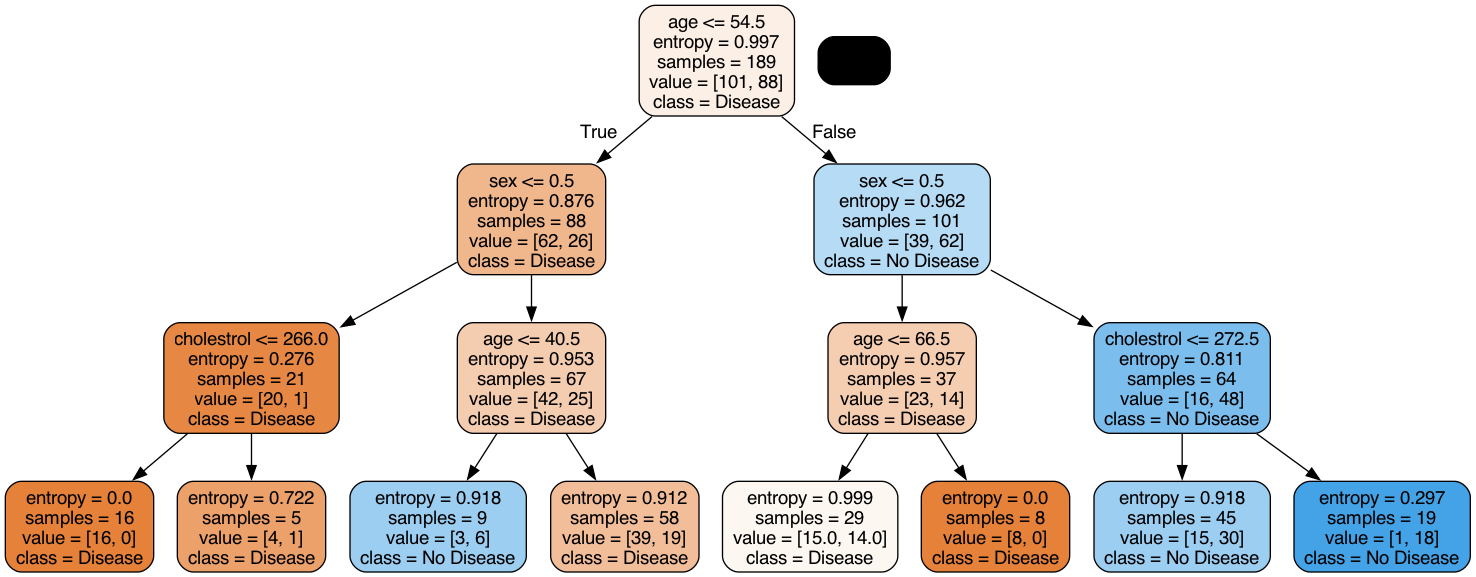

In [128]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())

In [131]:
dt_best.transformer = generalDtTransformer
dt_best.mainPredictor = partial(generalDtPredictor,dt_best)
y_pred = dt_best.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

dt_best_metadata = {
    "modelName": "dTModelBestAccuracy",
    "version": "1.0.1",
    "params": dt_best.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_best.feature_importances_.tolist(),
        "n_features": int(dt_best.n_features_in_),
        "n_classes": int(dt_best.n_classes_),
        "classes": dt_best.classes_.tolist(),
        "depth": int(dt_best.get_depth()),
        "n_leaves": int(dt_best.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}
registerAJrjModel(
    dt_best,
    dt_best_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelBestAccuracy__1.0.1.pkl.zip
❌ Failed to generate URL or upload: E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelBestAccuracy", version: "1.0.1" }, full error: {'index': 0, 'code': 11000, 'errmsg': 'E11000 duplicate key error collection: jrjModelRegistry.models index: modelName_1_version_1 dup key: { modelName: "dTModelBestAccuracy", version: "1.0.1" }', 'keyPattern': {'modelName': 1, 'version': 1}, 'keyValue': {'modelName': 'dTModelBestAccuracy', 'version': '1.0.1'}}


# tune for f1


In [132]:
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "f1")

In [133]:
%%time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
CPU times: user 60.9 ms, sys: 10.6 ms, total: 71.5 ms
Wall time: 87.9 ms


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='f1', verbose=1)

In [134]:
score_df = pd.DataFrame(grid_search.cv_results_)
score_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001099,0.000114,0.001454,0.000239,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.666667,0.684211,0.500000,0.421053,0.567982,0.111195,27
1,0.001243,0.000047,0.001558,0.000087,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.666667,0.684211,0.500000,0.421053,0.567982,0.111195,27
2,0.001098,0.000116,0.001506,0.000205,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.634146,0.684211,0.500000,0.421053,0.559852,0.104681,33
3,0.001166,0.000215,0.001415,0.000197,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.666667,0.680851,0.565217,0.708333,0.655267,0.054105,1
4,0.001144,0.000021,0.001369,0.000079,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41


In [135]:
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
3,0.001166,0.000215,0.001415,0.000197,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.666667,0.680851,0.565217,0.708333,0.655267,0.054105,1
8,0.001017,0.000129,0.001289,0.000091,gini,3,50,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.666667,0.680851,0.565217,0.708333,0.655267,0.054105,1
13,0.001213,0.000152,0.001656,0.000616,gini,5,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.666667,0.680851,0.565217,0.708333,0.655267,0.054105,1
18,0.000915,0.000183,0.001058,0.000103,gini,10,50,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.666667,0.680851,0.565217,0.708333,0.655267,0.054105,1
23,0.000942,0.000092,0.001129,0.000031,gini,20,50,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.666667,0.680851,0.565217,0.708333,0.655267,0.054105,1


In [136]:
grid_search.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=50, random_state=42)

In [137]:
dt_best = grid_search.best_estimator_

In [138]:
evaluate_model(dt_best)

Train Accuracy : 0.656084656084656
Train Confusion Matrix:
[[62 39]
 [26 62]]
--------------------------------------------------
Test Accuracy : 0.5925925925925926
Test Confusion Matrix:
[[30 19]
 [14 18]]


In [139]:
from sklearn.metrics import classification_report

In [140]:
print(classification_report(y_test, dt_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.61      0.65        49
           1       0.49      0.56      0.52        32

    accuracy                           0.59        81
   macro avg       0.58      0.59      0.58        81
weighted avg       0.60      0.59      0.60        81



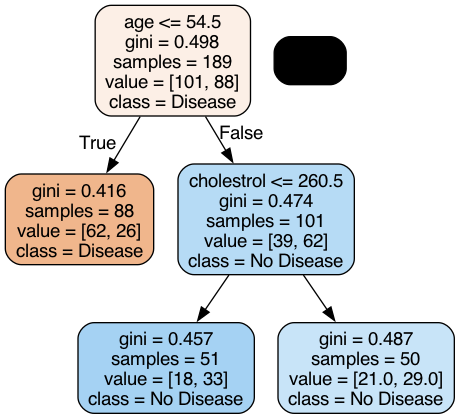

In [141]:
gph = get_dt_graph(dt_best)
Image(gph.create_png())

In [142]:
dt_best.transformer = generalDtTransformer
dt_best.mainPredictor = partial(generalDtPredictor,dt_best)
y_pred = dt_best.predict(generalDtTransformer(X_test))
# y_pred
score = accuracy_score(y_test, y_pred)
# score
report = classification_report(y_test, y_pred, output_dict=True)
# report

dt_best_metadata = {
    "modelName": "dTModelBestF1",
    "version": "1.0.1",
    "params": dt_best.get_params(),  # All model hyperparameters
    "score": float(score),         # Accuracy
    "modelLibrary": "sklearn.tree.DecisionTreeClassifier",
    "libraryMetadata": {
        "feature_importances": dt_best.feature_importances_.tolist(),
        "n_features": int(dt_best.n_features_in_),
        "n_classes": int(dt_best.n_classes_),
        "classes": dt_best.classes_.tolist(),
        "depth": int(dt_best.get_depth()),
        "n_leaves": int(dt_best.get_n_leaves()),
        "classification_report": report
    },
     "sampleData": {
        "dataForTransfer": hDSampleData
    }
}
registerAJrjModel(
    dt_best,
    dt_best_metadata
)

✅ Uploaded encrypted ZIP to s3://jasonjafariml/dTModelBestF1__1.0.1.pkl.zip


{'_id': '685541eb38947ba330a5f876',
 'modelName': 'dTModelBestF1',
 'version': '1.0.1',
 'params': {'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 2,
  'max_features': None,
  'max_leaf_nodes': None,
  'min_impurity_decrease': 0.0,
  'min_samples_leaf': 50,
  'min_samples_split': 2,
  'min_weight_fraction_leaf': 0.0,
  'monotonic_cst': None,
  'random_state': 42,
  'splitter': 'best'},
 'score': 0.5925925925925926,
 'modelLibrary': 'sklearn.tree.DecisionTreeClassifier',
 'libraryMetadata': {'feature_importances': [0.9767403709553542,
   0.0,
   0.0,
   0.023259629044645902],
  'n_features': 4,
  'n_classes': 2,
  'classes': [0, 1],
  'depth': 2,
  'n_leaves': 3,
  'classification_report': {'0': {'precision': 0.6818181818181818,
    'recall': 0.6122448979591837,
    'f1-score': 0.6451612903225806,
    'support': 49.0},
   '1': {'precision': 0.4864864864864865,
    'recall': 0.5625,
    'f1-score': 0.5217391304347826,
    'support': 32.0},
   'accuracy': 